In [90]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt


# Synthetic Dataset Construction

In [91]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [92]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [93]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

# TODO: 
def gd(A, b_onehot, max_iter=1000, eta=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= eta * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist.append({
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            })

    hist_df = pd.DataFrame(hist)
    return hist_df

In [94]:
hist_gd_df = gd(A,b_onehot, eta=1)
hist_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,70.591026,0.026,0.270587,0.171875,0.053066
1,1,68.536983,0.027,0.269164,0.359375,0.080217
2,2,66.520447,0.029,0.267798,0.546875,0.116342
3,3,64.545392,0.034,0.265771,0.703125,0.140443
4,4,62.614586,0.038,0.263072,0.859375,0.165870
...,...,...,...,...,...,...
995,995,0.000777,1.000,0.000168,72.468750,12.599517
996,996,0.000777,1.000,0.000168,72.500000,12.612261
997,997,0.000776,1.000,0.000168,72.593750,12.625369
998,998,0.000775,1.000,0.000168,72.765625,12.638103


Sources:
https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372

# BCGD

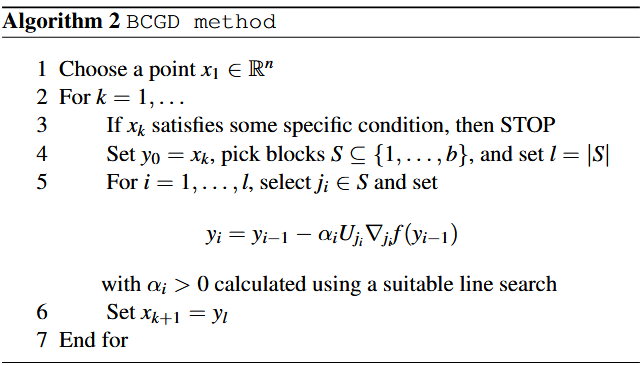

In [95]:
#TODO: calculate lipshitz constant.
L = 0.01
alpha = 1/L

In [96]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    
    X_out = X0
    X_out[:,i_k] += step.flatten()
    return X_out



# TODO: check optimality condition for early stopping.
def BCGD(coord_select, coord_step=coord_step, max_iter = 100, return_hist = True, step_size = alpha):
    # X_DEBUG = None
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        #X_cur = coord_step(X_cur, i_k, g_ik)
        coord_step(X_cur, i_k, g_ik, alpha=step_size)
        # if iter == 5:
        #     X_DEBUG = np.copy(X_cur)
        #     print('whoo')
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist.append(hist_iter)
    if return_hist:
        return pd.DataFrame(hist)#, X_DEBUG
    else:
        return

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    g = grad(A, b_onehot, X)
    i_k = np.random.randint(num_classes) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

In [104]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200)
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,70.624681,0.046,22,0.235369,0.062500,0.026142
1,1,68.497192,0.069,0,0.232594,0.234375,0.051436
2,2,66.496238,0.086,44,0.230917,0.359375,0.072007
3,3,64.632280,0.106,14,0.230803,0.453125,0.096006
4,4,62.942370,0.130,21,0.233219,0.703125,0.119349
...,...,...,...,...,...,...,...
195,195,0.000063,1.000,0,0.000063,17.250000,3.165989
196,196,0.000063,1.000,21,0.000062,17.359375,3.177990
197,197,0.000062,1.000,29,0.000062,17.390625,3.189694
198,198,0.000062,1.000,41,0.000061,17.453125,3.201368


In [ ]:
hist_BCGD_GS_ls_df, X_DEBUG = BCGD(gs_coord_select, coord_step=coord_step_linesearch, max_iter=200)
hist_BCGD_GS_ls_df

whoo


,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,7.143038e+01,0.039,20,2.580437e-01,0.609375,0.108032
1,1,6.914461e+01,0.069,14,2.507619e-01,1.375000,0.219006
2,2,6.734976e+01,0.090,28,2.420108e-01,2.031250,0.321704
3,3,6.548380e+01,0.109,41,2.339672e-01,2.812500,0.432940
4,4,6.334526e+01,0.131,49,2.333299e-01,3.578125,0.545568
...,...,...,...,...,...,...,...
195,195,9.322517e-07,1.000,33,9.639771e-07,609.500000,86.614602
196,196,9.279818e-07,1.000,32,9.583521e-07,614.515625,87.306857
197,197,9.236588e-07,1.000,8,9.555779e-07,619.906250,88.002918
198,198,9.193661e-07,1.000,49,9.462146e-07,624.953125,88.707473


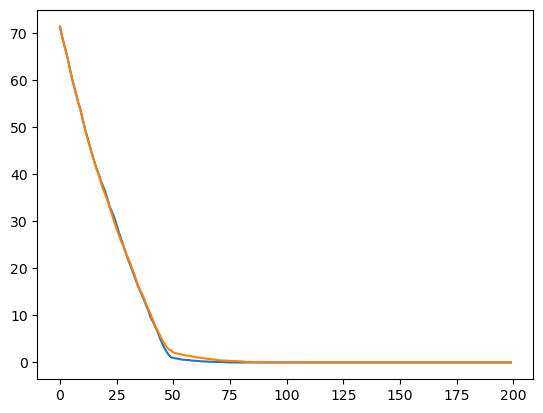

In [ ]:
plt.figure()
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['loss'])
plt.plot(hist_BCGD_GS_df['iter'], hist_BCGD_GS_df['loss'])

In [105]:
g_ik, i_k = gs_coord_select(X_DEBUG)
X_cur = np.copy(X_DEBUG)
def coord_step_linesearch(X_cur, i_k, g_ik):
    #hist_ls = []
    prev_loss = 1e10
    for i in range(100):
        step = - i * g_ik
        X_cur[:,i_k] += step.flatten()
        l = loss(A,b_onehot, X_cur)#
        # hist_ls.append({
        #     'iter': i,
        #     'loss': l
        # })
        if l > prev_loss:
            # by convexity, if the loss increases along our line search, stop searching.
            break
        prev_loss = l
# ls_df = pd.DataFrame(hist_ls)
# ls_df


NameError: name 'X_DEBUG' is not defined

In [99]:
ls_df['loss'].plot()

NameError: name 'ls_df' is not defined

In [106]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500)
hist_BCGD_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,70.912480,0.046,13,0.200491,0.125000,0.033167
1,1,69.544397,0.065,17,0.206843,0.312500,0.059296
2,2,67.712826,0.084,36,0.213401,0.421875,0.084419
3,3,66.482064,0.095,48,0.192681,0.531250,0.110225
4,4,64.851530,0.115,2,0.218959,0.671875,0.136981
...,...,...,...,...,...,...,...
495,495,0.000031,1.000,27,0.000019,33.406250,6.661919
496,496,0.000031,1.000,8,0.000082,33.500000,6.669890
497,497,0.000030,1.000,44,0.000037,33.578125,6.684943
498,498,0.000030,1.000,44,0.000034,33.593750,6.695183


In [107]:
def plot_hist(X_val, Y_val, dfs, legend_lables):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.

    fig = plt.figure()
    for i, hist_df in enumerate(dfs):
        plt.plot(hist_df[X_val], hist_df[Y_val], label=legend_lables[i])
    # plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    # plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    # plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.show()

In [108]:
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,70.624681,0.046,22,0.235369,0.062500,0.026142
1,1,68.497192,0.069,0,0.232594,0.234375,0.051436
2,2,66.496238,0.086,44,0.230917,0.359375,0.072007
3,3,64.632280,0.106,14,0.230803,0.453125,0.096006
4,4,62.942370,0.130,21,0.233219,0.703125,0.119349
...,...,...,...,...,...,...,...
195,195,0.000063,1.000,0,0.000063,17.250000,3.165989
196,196,0.000063,1.000,21,0.000062,17.359375,3.177990
197,197,0.000062,1.000,29,0.000062,17.390625,3.189694
198,198,0.000062,1.000,41,0.000061,17.453125,3.201368


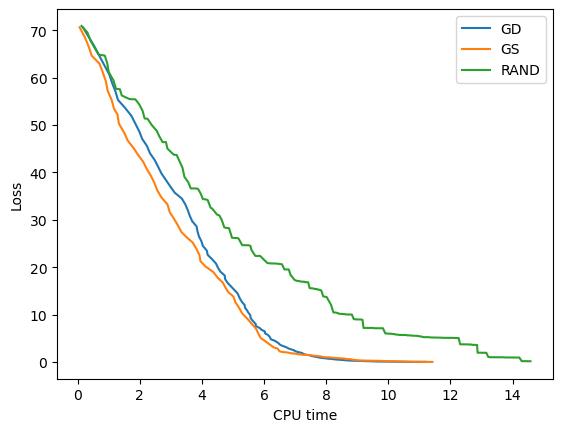

In [110]:
gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.
plot_hist('cpu_time', 'loss', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

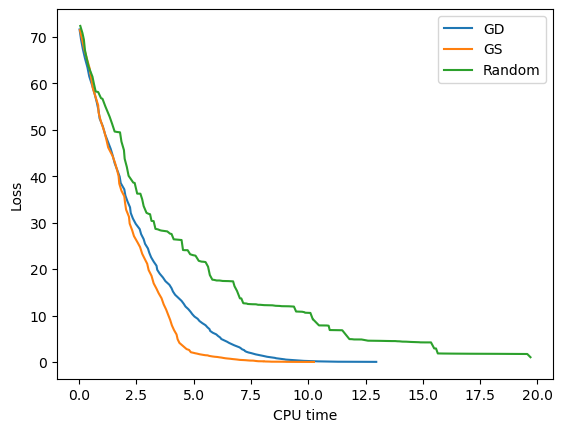

In [144]:
plot_hist('cpu_time', 'loss')

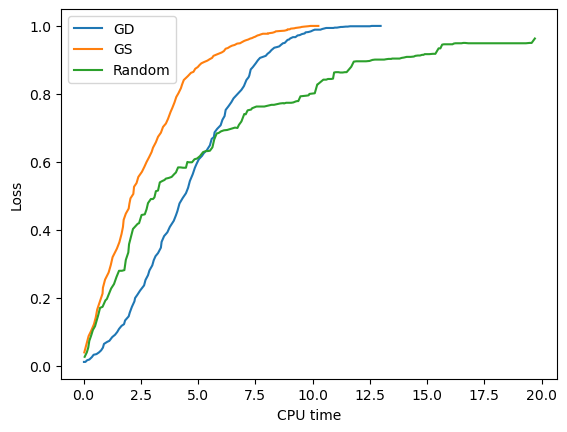

In [145]:
plot_hist('cpu_time', 'accuracy')

In [111]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
iris = fetch_ucirepo(id=53) 
A_df = iris.data.features 
class_df = iris.data.targets 

In [112]:
A_df.to_numpy(dtype=float)

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [113]:
b_names = class_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = class_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = A_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [114]:
gd_iris_df = gd(A, b_onehot)
gd_iris_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,9.904119,0.333333,6.232681,0.0000,0.003013
1,1,6.210709,0.333333,6.211637,0.0000,0.005011
2,2,5.412714,0.333333,4.689107,0.0000,0.006009
3,3,4.809520,0.333333,4.633337,0.0000,0.006009
4,4,4.133593,0.333333,4.676296,0.0000,0.007009
...,...,...,...,...,...,...
995,995,0.132608,0.960000,0.022683,2.0625,0.381175
996,996,0.132556,0.960000,0.022664,2.0625,0.381175
997,997,0.132504,0.960000,0.022645,2.0625,0.381175
998,998,0.132452,0.960000,0.022625,2.0625,0.381175


In [116]:
bcgd_gs_iris_df = BCGD(gs_coord_select, step_size=0.1, max_iter=500)
bcgd_gs_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,11.303152,0.333333,1,5.051307,0.000000,0.000993
1,1,8.762375,0.333333,1,5.048476,0.000000,0.000993
2,2,6.394965,0.333333,1,4.992881,0.000000,0.000993
3,3,5.126085,0.333333,1,4.224321,0.000000,0.000993
4,4,4.693359,0.333333,0,2.080209,0.000000,0.000993
...,...,...,...,...,...,...,...
495,495,0.242408,0.966667,0,0.047029,0.640625,0.150955
496,496,0.242187,0.966667,2,0.046995,0.640625,0.150955
497,497,0.241968,0.966667,2,0.046912,0.640625,0.150955
498,498,0.241748,0.966667,2,0.046829,0.640625,0.150955


In [117]:
bcgd_rand_iris_df = BCGD(rand_coord_select, step_size=0.1, max_iter=500)
bcgd_rand_iris_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,11.303152,0.333333,1,5.051307,0.031250,0.002004
1,1,10.337659,0.333333,2,3.109498,0.046875,0.004300
2,2,7.844392,0.333333,1,5.035092,0.046875,0.004300
3,3,7.411664,0.333333,0,2.080213,0.046875,0.005299
4,4,5.526781,0.333333,1,4.751675,0.046875,0.005579
...,...,...,...,...,...,...,...
495,495,0.290244,0.953333,1,0.022359,1.062500,0.245043
496,496,0.290035,0.953333,0,0.045789,1.062500,0.245043
497,497,0.289985,0.953333,1,0.022580,1.062500,0.245043
498,498,0.289935,0.953333,1,0.022295,1.062500,0.246048


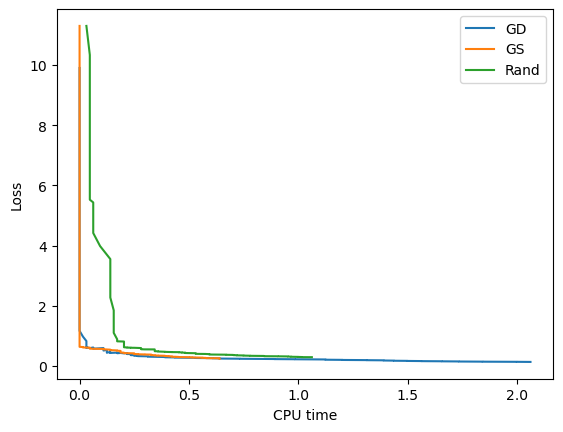

In [118]:
plot_hist('cpu_time', 'loss', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])

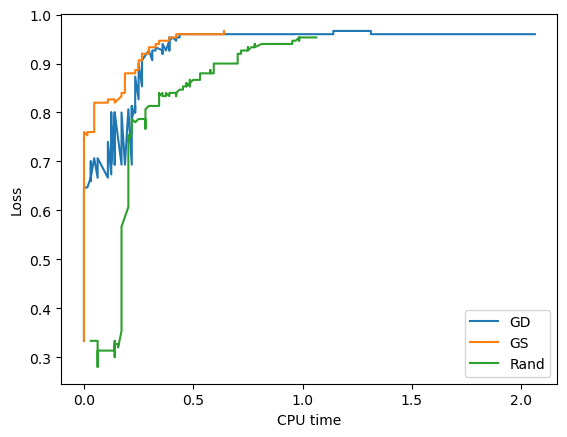

In [119]:
plot_hist('cpu_time', 'accuracy', [gd_iris_df, bcgd_gs_iris_df, bcgd_rand_iris_df], legend_lables=['GD', 'GS', 'Rand'])